## Calibrando Modelos de Regressão com Previsão Conforme

Previsão Conforme (em inglês Conformal Prediction) é um método que transforma as previsões pontuais em conjuntos de previsões. Dessa forma, fornece previsões associadas à um nível de confiança estatística, permitindo que sejam medidos e controlados os riscos de uma previsão estar errada.


### Importar Libs

In [ ]:
#%pip install -U numpy pandas sklearn wget matplotlib seaborn

In [ ]:
#%pip install mapie --use-deprecated=legacy-resolver

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.max_rows=50

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
style.use("fivethirtyeight")

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_absolute_error

from mapie.regression import MapieRegressor
from mapie.quantile_regression import MapieQuantileRegressor
from mapie.metrics import regression_coverage_score
from mapie.metrics import regression_mean_width_score

### Importar Dataset

In [2]:
# Import data
rent = pd.read_csv("http://www.bamlss.org/misc/rent99.raw", sep=' ')
y = rent["rentsqm"]
X = rent.drop(["rent", "rentsqm", "cheating"], axis = 1)

# Train/Test/Calib split
X_train, X_rest1, y_train, y_rest1 = train_test_split(
X, y, test_size=2000, random_state=2
)

X_test, X_rest2, y_test, y_rest2 = train_test_split(
X_rest1, y_rest1, test_size=1500, random_state=4
)

X_calib, X_new, y_calib, y_new = train_test_split(
X_rest2, y_rest2, test_size=500, random_state=42
)

"Data sizes: train: %i, test: %i, calibration: %i, new: %i" % (
len(X_train), len(X_test), len(X_calib), len(X_new)
)

'Data sizes: train: 1082, test: 500, calibration: 1000, new: 500'

### Train Model - Random Forest Regressor

In [3]:
# These are the parameters that we want to optimize
params = {
'n_estimators': [10, 50, 100, 500, 1000],
'max_depth': [None, 1, 2, 5, 10],
'min_samples_split': [2, 5, 10],
'min_samples_leaf': [1, 2, 4],
}

# The model is a random forest
model = RandomForestRegressor()

# Create the random search object using 5-fold cross-validation
random_search = RandomizedSearchCV(
estimator=model, param_distributions=params, cv=5,
n_iter=10, random_state=0
)

# Fit the random search to the data
random_search.fit(X_train, y_train)

# Fit the best model from random search to the data
model = RandomForestRegressor(
**random_search.best_params_, random_state=1
)

model.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, min_samples_leaf=4, n_estimators=500,
                      random_state=1)

In [4]:
# Make predictions using the fitted model
y_pred = model.predict(X_test)
# Calculate the mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print(round(mae, 2))

1.64


### Conformal Prediction - Random Forest Regressor

In [5]:
mapie_reg = MapieRegressor(estimator=model, cv="prefit")
mapie_reg.fit(X_calib, y_calib)
y_pred, y_pis = mapie_reg.predict(X_new, alpha=1/3)

In [6]:
print(X_new.iloc[4])
print("------- Rent per Squared Meter -------")
print("True rent: {:.2f}".format(y_new.iloc[4]))
print("Predicted rent: {:.2f}".format(y_pred[4]))
interval = y_pis[4].flatten()
print("67% interval: [{:.2f};{:.2f}]".format(interval[0], interval[1]))
print("------- Total Rent -------")
print("True rent: {:.2f}".format(y_new.iloc[4]*X_new.iloc[4][0]))
print("Predicted rent: {:.2f}".format(y_pred[4]*X_new.iloc[4][0]))
print("67% interval: [{:.2f};{:.2f}]".format(interval[0]*X_new.iloc[4][0], interval[1]*X_new.iloc[4][0]))

area         70.000
yearc      1930.000
location      2.000
bath          0.000
kitchen       0.000
district    731.000
Name: 3005, dtype: float64
------- Rent per Squared Meter -------
True rent: 7.15
Predicted rent: 6.11
67% interval: [4.20;8.01]
------- Total Rent -------
True rent: 500.36
Predicted rent: 427.50
67% interval: [293.95;561.05]


In [7]:
# Plots the quantile range of predicted values for given feature

def plot_quantile_by_feature(X, y, pred, qrs, feature_name):
    """
    - X (pandas DataFrame): Dataframe with features for the data.
    - y (pandas Series): Pandas series with the target variable.
    - pred (array-like): An array with predictions.
    - qrs (array-like): Quantile range for plotting.
    - feature_name (string): The name of the feature being plotted.
    """
    xj= X[feature_name]
    # Sort the feature values
    order = np.argsort(xj.values)
    
    # Create a scatter plot of the actual values
    plt.scatter(xj, y.values, color="black", alpha=1/3)
    
    # Plot lower and upper quantile in dashed lines
    plt.plot(xj.values[order], qrs[order][:,0], color="C1", ls="--", linewidth=0.6)
    plt.plot(xj.values[order], qrs[order][:,1], color="C1", ls="--", linewidth=0.6)
    
    # Paint the region between the quantiles
    plt.fill_between(xj.values[order].ravel(),
                     qrs[order][:,0].ravel(),
                     qrs[order][:,1].ravel(),
                     alpha=0.3)
    
    # Label the x-axis with the feature name
    plt.xlabel(feature_name)
    
    # Label the y-axis with the label "predicted rent per sqm"
    plt.ylabel("predicted rent per sqm")

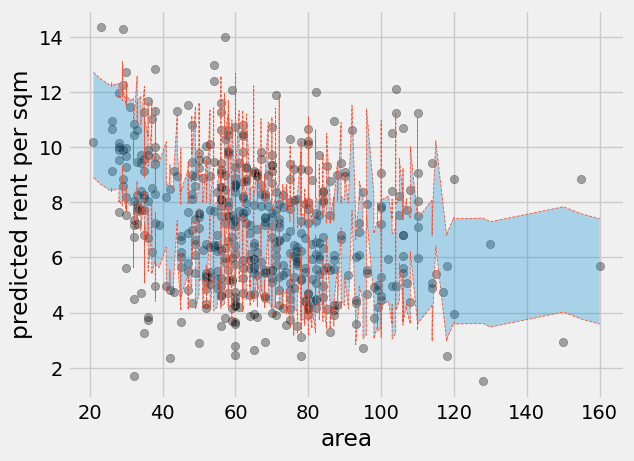

In [8]:
plot_quantile_by_feature(X_new, y_new, y_pred, y_pis, "area")

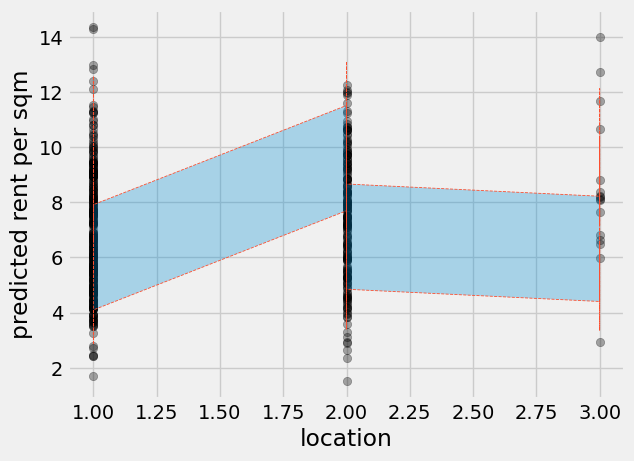

In [9]:
plot_quantile_by_feature(X_new, y_new, y_pred, y_pis, "location")

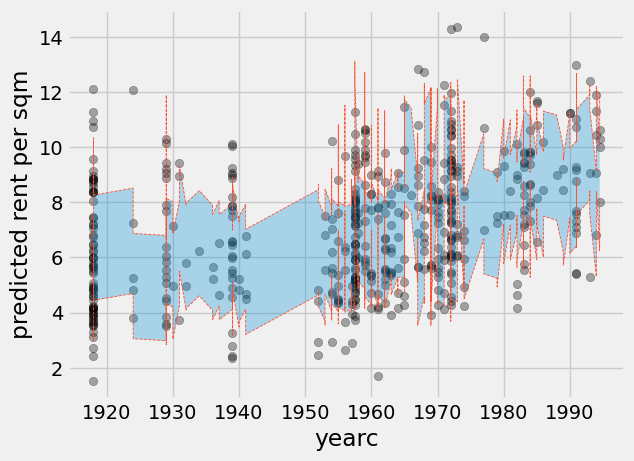

In [10]:
plot_quantile_by_feature(X_new, y_new, y_pred, y_pis, "yearc")

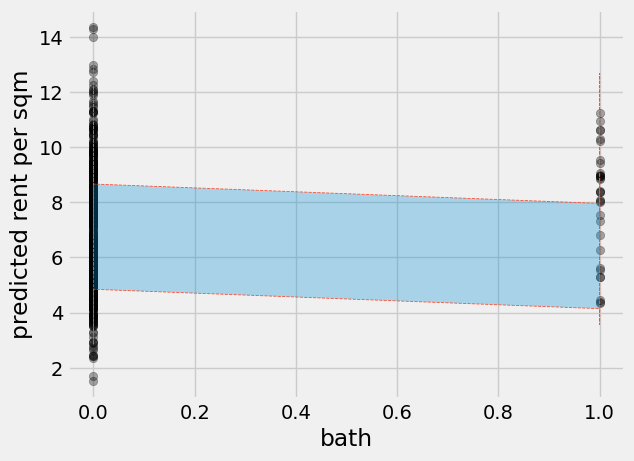

In [11]:
plot_quantile_by_feature(X_new, y_new, y_pred, y_pis, "bath")

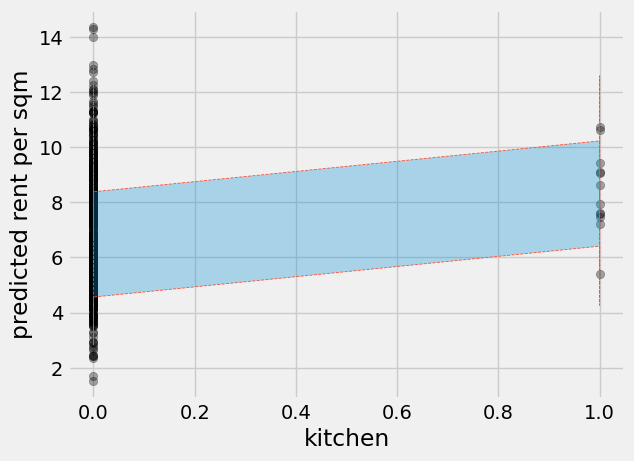

In [12]:
plot_quantile_by_feature(X_new, y_new, y_pred, y_pis, "kitchen")

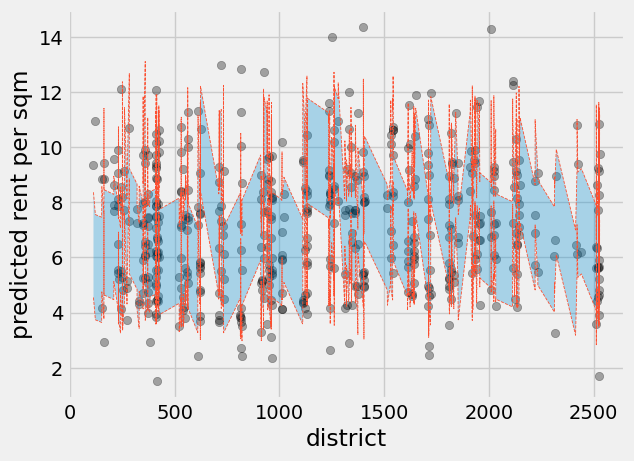

In [13]:
plot_quantile_by_feature(X_new, y_new, y_pred, y_pis, "district")

In [14]:
size = regression_mean_width_score(y_pis[:,0], y_pis[:,1])
print("Avg. interval size: {:.2f}".format(size))
cov = regression_coverage_score(y_new, y_pis[:,0], y_pis[:,1])
print("Coverage: {:.2%}".format(cov))

Avg. interval size: 3.82
Coverage: 68.20%


### Conformalized Quantile Regression (CQR) - Theoretical Example

In [15]:
# alpha = .05
# 
# # 1. Fit quantile regression model on training data
# model = RandomForestQuantileRegressor().fit(X_train, y_train)
# 
# # 2. Make prediction on calibration data
# y_calib_interval_pred = np.column_stack([
#     model.predict(X_calib, quantile=(alpha/2)*100), 
#     model.predict(X_calib, quantile=(1-alpha/2)*100)])
# 
# # 3. Compute conformity scores on calibration data
# y_calib_conformity_scores = np.maximum(
#   y_calib_interval_pred[:,0] - y_calib, 
#   y_calib - y_calib_interval_pred[:,1])
# 
# # 4. Get 1-alpha quantile from the distribution of conformity scores Note: this is a single number
# quantile_conformity_scores = np.quantile(
#     y_calib_conformity_scores, 1-alpha)
# 
# # 5. Make prediction on test data
# y_test_interval_pred = np.column_stack([
#     model.predict(X_test, quantile=(alpha/2)*100), 
#     model.predict(X_test, quantile=(1-alpha/2)*100)])
# 
# # 6. Compute left (right) end of the interval by subtracting (adding) the quantile to the predictions
# y_test_interval_pred_cqr = np.column_stack([
#     y_test_interval_pred[:,0] - quantile_conformity_scores,
#     y_test_interval_pred[:,1] + quantile_conformity_scores])

### Conformalized Quantile Regression (CQR) - MAPIE

In [16]:
# Defining the quantiles for the models
# Make sure to have the order right: lower, upper, median
alphas = [1/6, 5/6, 0.5]
models = []

for a in alphas:
    m = GradientBoostingRegressor(loss='quantile',alpha=a)
    m.fit(X_train, y_train)
    models.append(m)

In [17]:
cqr = MapieQuantileRegressor(models, alpha=1/3, cv="prefit")
cqr.fit(X_calib, y_calib)
y_pred, y_qr = cqr.predict(X_new, alpha = 1/3)

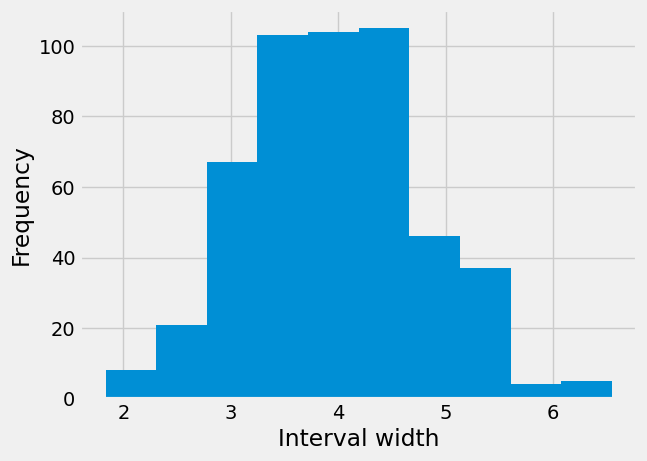

In [18]:
# Compute the distances of upper and lower bounds
widths = y_qr[:,1] - y_qr[:,0]
plt.hist(widths)
# Label the x-axis
plt.xlabel("Interval width")
# Label the y-axis
plt.ylabel("Frequency")
plt.show()

In [19]:
for i in range(5):
    print("%.3f [%.3f;%.3f]" % (y_pred[i], y_qr[i,0], y_qr[i,1]))

5.948 [4.132;8.440]
6.947 [4.058;9.394]
4.912 [3.570;8.260]
9.647 [8.565;11.892]
6.100 [3.440;8.782]


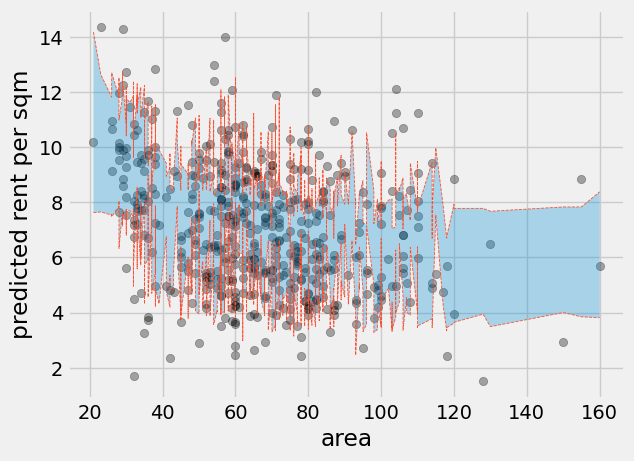

In [20]:
plot_quantile_by_feature(X_new, y_new, y_pred, y_qr, "area")

In [21]:
size = regression_mean_width_score(y_qr[:,0], y_qr[:,1])
print("Average interval width: {:.2f}".format(size))
cov = regression_coverage_score(y_new, y_qr[:,0], y_qr[:,1])
print("Coverage: {:.2%}".format(cov))

Average interval width: 3.97
Coverage: 67.40%


In [22]:
def regression_calibration_curve(estimator, X, y, alphas=np.linspace(0.1, 1, 10, endpoint=True)):
    errors = []
    interval_sizes = []
    for a in alphas:
        pred = estimator.predict(X, significance=a)
        interval_sizes.append(np.mean([y-x for x, y in pred]))
        errors.append(1 - np.mean([x <= z and z <= y for (x,y), z in zip(pred, y)]))
    return errors, interval_sizes

def regression_calibration_plot(estimator, X, y, alphas=np.linspace(0.1, 1, 10, endpoint=True)):
    errors, interval_sizes = regression_calibration_curve(estimator,X,y,alphas)
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot([0,1], [0,1])
    ax1.plot(alphas, errors, 'o')
    ax2.plot(alphas, interval_sizes, '=')
    ax1.set_xlabel('Significanc')
    ax1.set_ylabel('Error Rate')
    ax2.set_ylabel('Avg. Interval Size')
    plt.title('Regression Conformal Calibration Curve')
    plt.show()

In [ ]:
regression_calibration_plot(cqr, X_new, y_new)